In [30]:
import pandas as pd
import nltk
import numpy as np
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import torch
from transformers import pipeline
import textwrap
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from collections import Counter
from wordcloud import WordCloud


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/gulsumasenacakir/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


#### Data Prep

In [31]:
df = pd.read_csv("/Users/gulsumasenacakir/Downloads/elden_ring_steam_reviews.csv")

In [32]:
df.head()

,id,language,review,created,voted_up,votes_up,comment_count,steam_purchase,recieved_for_free,written_during_early_access,author_num_games_owned,author_num_reviews,author_playtime_forever,author_playtime_last_two_weeks,author_playtime_at_review,author_last_played
0,134238864,english,being killed over and over again is fun,2023-03-07 14:19:11,True,0,0,False,False,False,47,2,355,355,346,2023-03-07 14:29:21
1,134238208,english,I write this review as I have 100% completed E...,2023-03-07 14:03:24,True,0,0,True,False,False,110,2,24238,5823,24238,2023-03-07 02:08:22
2,134238033,english,Fun,2023-03-07 13:59:13,True,0,0,True,False,False,11,1,912,912,881,2023-03-07 14:30:07
3,134237508,english,pretty cool.,2023-03-07 13:46:37,True,0,0,True,False,False,94,8,8497,2914,8497,2023-03-07 13:44:52
4,134236511,english,AMAZINGGGGGGGGGGGGG,2023-03-07 13:20:04,True,0,0,True,False,False,4,1,985,163,923,2023-03-07 14:26:41


In [33]:
df.shape

(9794, 16)

In [34]:
df_check = pd.DataFrame({
    'unique_values': df.nunique(),
    'missing_values': df.isnull().sum(),
    'types': df.dtypes
})
df_check

,unique_values,missing_values,types
id,9794,0,int64
language,1,0,object
review,8344,29,object
created,9777,0,object
voted_up,2,0,bool
votes_up,34,0,int64
comment_count,10,0,int64
steam_purchase,2,0,bool
recieved_for_free,2,0,bool
written_during_early_access,1,0,bool


In [35]:
# remove null values
df = df.dropna()
df.shape

(9765, 16)

In [36]:
# remove the columns with one unique value
df = df.drop(['language', 'written_during_early_access'], axis=1)
df.shape

(9765, 14)

In [37]:
## add new feature to count the length of review
df['length_review'] = df['review'].apply(lambda x: len(x.split()))

In [38]:
df[['review', 'length_review']].head()

,review,length_review
0,being killed over and over again is fun,8
1,I write this review as I have 100% completed E...,663
2,Fun,1
3,pretty cool.,2
4,AMAZINGGGGGGGGGGGGG,1


#### EDA - Word Cloud

In [39]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gulsumasenacakir/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
def clean_text(text):
    if isinstance(text, str):  
        text = text.lower()  
        text = re.sub(r'\d+', '', text)  # Remove numbers
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation and special characters
        text = re.sub(r'[\U00010000-\U0010FFFF]', '', text)  # Remove emojis
        text = re.sub(r'\s+', ' ', text).strip()  # Replace multiple spaces with a single space and trim
        words = text.split()  # Split text into a list of words
        words = [word for word in words if word not in stop_words]  # Remove stopwords
        return words
    return []  

In [41]:
df_cloud = df[['review']]
df_cloud['clean_review'] = df['review'].apply(lambda x: clean_text(x))

/var/folders/dr/bkbhk3k17yd_fvc3q6mtfkmw0000gn/T/ipykernel_3650/1098608451.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cloud['clean_review'] = df['review'].apply(lambda x: clean_text(x))


In [42]:
df_cloud.head()

,review,clean_review
0,being killed over and over again is fun,"[killed, fun]"
1,I write this review as I have 100% completed E...,"[write, review, completed, elden, ring, yet, d..."
2,Fun,[fun]
3,pretty cool.,"[pretty, cool]"
4,AMAZINGGGGGGGGGGGGG,[amazinggggggggggggg]


In [43]:
def word_frequency(text_list):
    word_counts = Counter()
    for words in text_list:
        word_counts.update(words)
    return word_counts

df_word_clouds = df_cloud["clean_review"]
word_clouds = word_frequency(df_word_clouds)
word_clouds = pd.DataFrame(word_clouds.items(), columns=['word', 'count']).sort_values(by = 'count', ascending=False).head(200).reset_index()

In [44]:
word_cloud_1 = dict(zip(word_clouds['word'], word_clouds['count']))

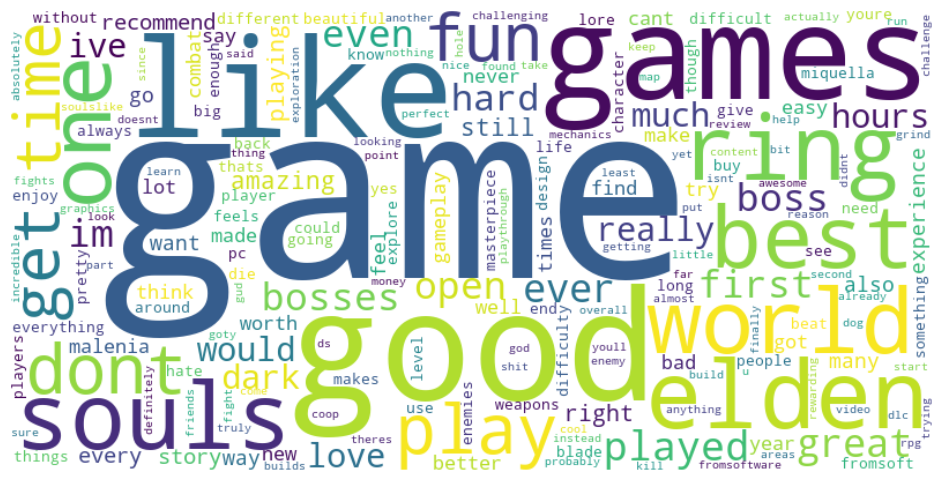

In [45]:
wordcloud1 = WordCloud(
    width=800, height=400,
    background_color='white',
    colormap='viridis',
    max_words=200
).generate_from_frequencies(word_cloud_1)


plt.figure(figsize=(12, 6))
plt.imshow(wordcloud1, interpolation="bilinear")
plt.axis("off")  
plt.show()

In [46]:
word_clouds.head(20)

,index,word,count
0,16,game,7589
1,247,good,1732
2,25,like,1341
3,200,games,1255
4,5,elden,1251
5,124,souls,1185
6,6,ring,1126
7,54,world,1109
8,395,best,1009
9,122,one,1000


There are similar words such as "game" vs. "games". To ensure consistency and avoid treating these variations as separate words, I am applying lemmatization.

In [47]:
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/gulsumasenacakir/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/gulsumasenacakir/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [48]:
lemmatizer = WordNetLemmatizer()

def lemmatize_text(words):
    return [lemmatizer.lemmatize(word) for word in words]

In [49]:
df_cloud['cleaner_review'] = df_cloud['clean_review'].apply(lemmatize_text)

/var/folders/dr/bkbhk3k17yd_fvc3q6mtfkmw0000gn/T/ipykernel_3650/498800737.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cloud['cleaner_review'] = df_cloud['clean_review'].apply(lemmatize_text)


In [55]:
df_word_clouds = df_cloud["cleaner_review"]
word_clouds = Counter()
for words in df_word_clouds:
    word_clouds.update(words)

In [56]:
word_clouds = pd.DataFrame(word_clouds.items(), columns=['word', 'count']).sort_values(by='count', ascending=False).head(200).reset_index(drop=True)

In [57]:
word_cloud_2 = dict(zip(word_clouds['word'], word_clouds['count']))

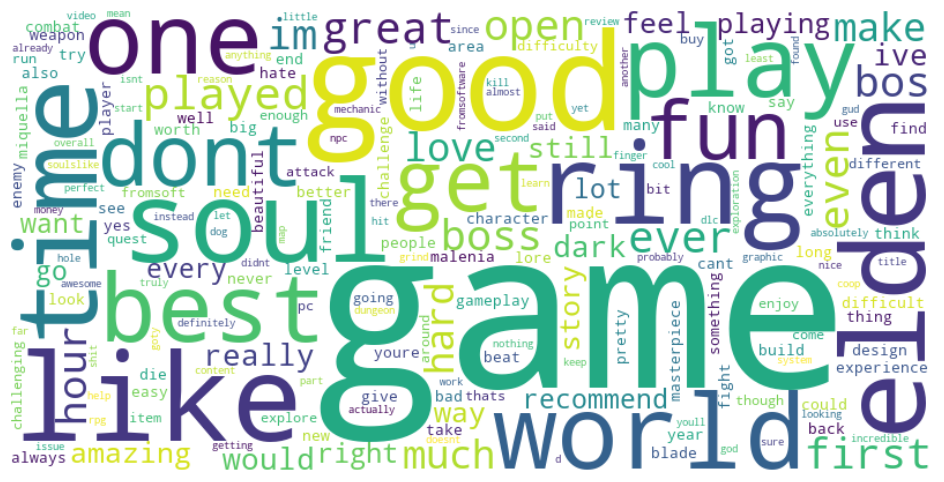

In [58]:
wordcloud2 = WordCloud(
    width=800, height=400,
    background_color='white',
    colormap='viridis',
    max_words=200
).generate_from_frequencies(word_cloud_2)


plt.figure(figsize=(12, 6))
plt.imshow(wordcloud2, interpolation="bilinear")
plt.axis("off")  
plt.show()

In [52]:
word_clouds.head(20)

,word,count
0,game,8844
1,good,1733
2,like,1369
3,elden,1251
4,soul,1234
5,time,1183
6,ring,1173
7,world,1139
8,one,1047
9,play,1024


In [59]:
word_clouds.to_csv('wordcloud.csv') # for Tableau visuals

#### Sentiment Analysis

##### 1- VADER

In [60]:
sia = SentimentIntensityAnalyzer()

In [61]:
df['sentiment_vader'] = df['review'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [62]:
df[df['sentiment_vader'] < 0][['review', 'sentiment_vader']]

,review,sentiment_vader
0,being killed over and over again is fun,-0.2960
7,"The game is super amazing and fun, easy to con...",-0.8316
9,Liar Ahead!,-0.5562
13,"I got 60+ hours into the game, before a friend...",-0.8126
15,"Honestly fun, challenging boss fights. Keeps t...",-0.5216
...,...,...
9768,i hated it.,-0.6369
9769,すべての実績がアンロックされました。 時間を盗む泥棒、宮崎英高！『エレデンリング』は“The...,-0.3129
9774,Its Elden Ring how could you not love it,-0.5216
9778,"very nice game and really cool graphics, but a...",-0.2135


In [63]:
df['label_vader'] = df['sentiment_vader'].apply(lambda x: 'positive' if x > 0 else ('negative' if x<0 else 'neutral') )

##### 2- BERT

In [64]:
device = 0 if torch.backends.mps.is_available() else -1  # MPS 
classifier = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment", device=device)

Device set to use mps:0


In [65]:
example = df['review'][0]
example

'being killed over and over again is fun'

In [66]:
classifier(example)

[{'label': '4 stars', 'score': 0.5098581910133362}]

In [67]:
def split_text(text, chunk_size=250):
    return textwrap.wrap(text, width=chunk_size)

def analyze_review(review):
    if len(review) <= 512:
        result = classifier(review)[0]
        return result["label"], result["score"]
    else:
        chunks = split_text(review, chunk_size=512)
        results = classifier(chunks)
        avg_score = np.mean([res["score"] for res in results])
        return results[0]["label"], avg_score


In [68]:
df[["sentiment_bert", "score_bert"]] = df["review"].apply(lambda x: pd.Series(analyze_review(x)))

#### Comparison

In [69]:
df[['review', 'label_vader', 'sentiment_bert']].head(10)

,review,label_vader,sentiment_bert
0,being killed over and over again is fun,negative,4 stars
1,I write this review as I have 100% completed E...,positive,5 stars
2,Fun,positive,4 stars
3,pretty cool.,positive,4 stars
4,AMAZINGGGGGGGGGGGGG,neutral,5 stars
5,good\n\n,positive,4 stars
6,Yes very hard but very fun also Berserk.,positive,4 stars
7,"The game is super amazing and fun, easy to con...",negative,4 stars
8,OHHHHHHHHHHHHHHHHH ELDEN RING,neutral,5 stars
9,Liar Ahead!,negative,1 star


In [70]:
vader_labels = df.groupby('label_vader')['id'].count().reset_index().rename(columns = {'id': 'cnt_vader'})
vader_labels

,label_vader,cnt_vader
0,negative,1565
1,neutral,2491
2,positive,5709


In [71]:
def label_posneg_net(sentiment_bert):
    if sentiment_bert == '1 star' or sentiment_bert == '2 stars':
        return 'negative'
    elif sentiment_bert == '3 stars':
        return 'neutral'
    else:
        return 'positive'
       

In [72]:
bert_labels = df.groupby('sentiment_bert')['id'].count().reset_index().rename(columns = {'id': 'cnt_bert'})
bert_labels['label_bert'] = bert_labels['sentiment_bert'].apply(lambda x: label_posneg_net(x))
bert_labels

,sentiment_bert,cnt_bert,label_bert
0,1 star,1477,negative
1,2 stars,436,negative
2,3 stars,1069,neutral
3,4 stars,1899,positive
4,5 stars,4884,positive


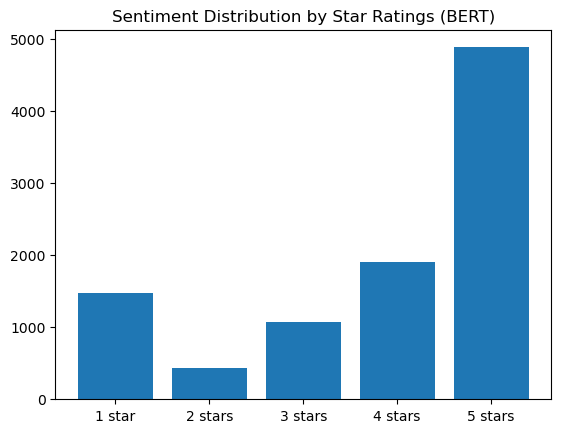

In [73]:
plt.bar(bert_labels['sentiment_bert'], bert_labels['cnt_bert'] )
plt.title('Sentiment Distribution by Star Ratings (BERT)')
plt.show()

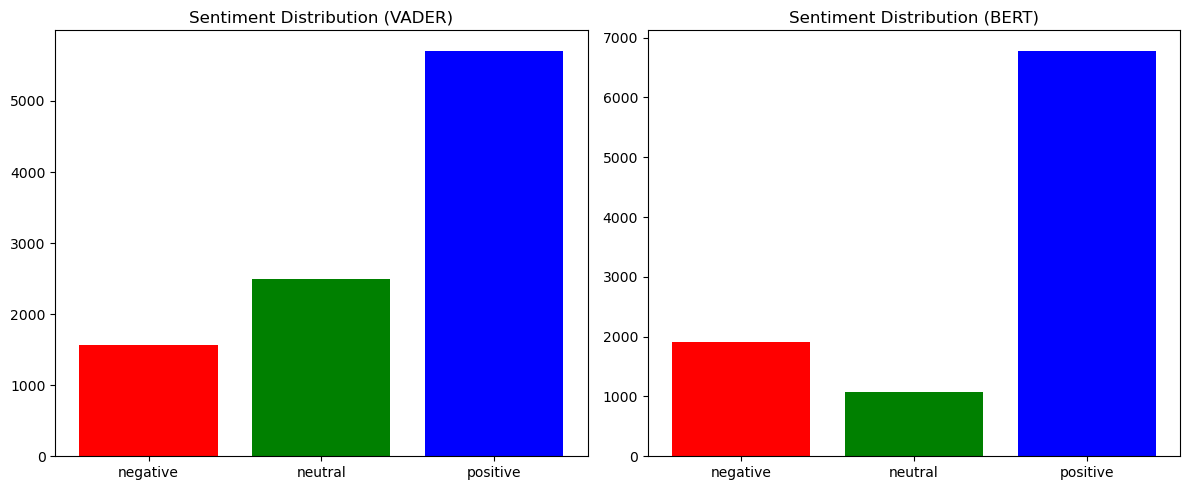

In [74]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].bar(vader_labels['label_vader'], vader_labels['cnt_vader'], color=['red', 'green', 'blue'])
axes[0].set_title('Sentiment Distribution (VADER)')

bert_grouped = bert_labels.groupby("label_bert")["cnt_bert"].sum().reset_index()
axes[1].bar(bert_grouped['label_bert'], bert_grouped['cnt_bert'], color=['red', 'green', 'blue'])
axes[1].set_title('Sentiment Distribution (BERT)')

plt.tight_layout()
plt.show()

In [75]:
df.to_csv('sentiment_results.csv')

In [76]:
df_new = df.drop('review', axis = 1)
df_new.to_csv('sentiment_results1.csv') # for Tableau
